In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

(논문에서는 224만큼의 사이즈를 추출하였지만 size를 맞추기 위해서는 227로 resize해야함)

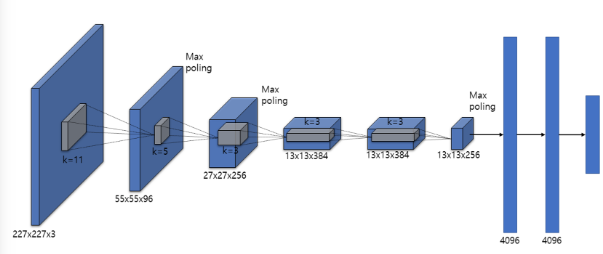

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Resize(227)])

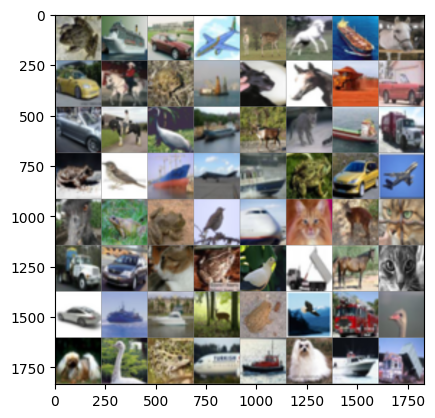

torch.Size([64, 3, 227, 227])


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

train_loader = DataLoader(trainset,
                          batch_size = 64,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(testset,
                         batch_size = 64,
                         shuffle=True,
                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [ ]:
# ReLU
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
        self.conv2 = nn.Conv2d(96, 256, 5, 1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, 1, 1)
        self.conv4 = nn.Conv2d(384, 384, 3, 1, 1)
        self.conv5 = nn.Conv2d(384, 256, 3, 1, 1)
        self.fc1 = nn.Linear(256*6*6, 4096)
        # 6*6 이 나오는 이유: Conv5까지 지나고 마지막 MaxPooling까지 하면 feature map 크기가 6 x 6으로 줄엉든다. 즉, 13-2/2 + 1 = 6
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.local_response_norm(x, size=5, alpha=0.0001, beta=0.75, k=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3, 2)
        x = F.local_response_norm(x, 5, 0.0001, 0.75, 2)

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 3, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)

        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)

        x = self.fc3(x)

        return x

model = AlexNet().to(device)
print(model)

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
# # 시그모이드 적용

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class AlexNet(nn.Module):
#     def __init__(self):
#         super(AlexNet, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
#         self.conv2 = nn.Conv2d(96, 256, 5, 1, padding=2)
#         self.conv3 = nn.Conv2d(256, 384, 3, 1, 1)
#         self.conv4 = nn.Conv2d(384, 384, 3, 1, 1)
#         self.conv5 = nn.Conv2d(384, 256, 3, 1, 1)
#         self.fc1 = nn.Linear(256*6*6, 4096)
#         self.fc2 = nn.Linear(4096, 4096)
#         self.fc3 = nn.Linear(4096, 10)

#     def forward(self, x):
#         x = torch.sigmoid(self.conv1(x))
#         x = F.max_pool2d(x, kernel_size=3, stride=2)
#         x = F.local_response_norm(x, size=5, alpha=0.0001, beta=0.75, k=2)

#         x = torch.sigmoid(self.conv2(x))
#         x = F.max_pool2d(x, 3, 2)
#         x = F.local_response_norm(x, 5, 0.0001, 0.75, 2)

#         x = torch.sigmoid(self.conv3(x))
#         x = torch.sigmoid(self.conv4(x))
#         x = torch.sigmoid(self.conv5(x))
#         x = F.max_pool2d(x, 3, 2)

#         x = x.view(x.size(0), -1)
#         x = torch.sigmoid(self.fc1(x))
#         x = F.dropout(x, p=0.5)

#         x = torch.sigmoid(self.fc2(x))
#         x = F.dropout(x, p=0.5)

#         x = self.fc3(x)

#         return x

# # 장치 설정 예시
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = AlexNet().to(device)
# print(model)


In [ ]:
# 손실함수, 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        current_correct = (predicted == labels).sum().item()
        correct += current_correct

        if batch_idx % 100 == 0:   # 배치수가 100개가 될 때마다 현재까지 배치 수, acc, loss 출력
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', current_correct / labels.size(0))
            print('Current batch average train loss:', loss.item() / labels.size(0))

        # 훈련이 모두 끝난 후 acc, loss 출력
        print('\nTotal average train accuarcy:', correct / total)
        print('Total average train loss:', train_loss / total)

In [ ]:
def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    model.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        total += labels.size(0)

        outputs = model(inputs)
        loss += criterion(outputs, labels).item()

        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()

    print('\nTotal average test accuarcy:', correct / total)
    print('Total average test loss:', loss / total)

    state = {
        'model': model.state_dict()
    }

    # 디렉토리 생성
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, f"./checkpoint/model_epoch_{epoch}.pth")
    print('Model Saved!')

In [ ]:
start_time = time.time()

for epoch in range(0, 10):
    train(epoch)
    test(epoch)

print('\nTime elapsed:', time.time() - start_time)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Total average train loss: 0.02600412169269093

Total average train accuarcy: 0.38276848591549295
Total average train loss: 0.026003843160267447

Total average train accuarcy: 0.38286744022503516
Total average train loss: 0.026002577606866296

Total average train accuarcy: 0.3828783356741573
Total average train loss: 0.026002241178216895

Total average train accuarcy: 0.38286728611500703
Total average train loss: 0.02600177248148313

Total average train accuarcy: 0.38292191876750703
Total average train loss: 0.02600053122595829

Total average train accuarcy: 0.38319493006993005
Total average train loss: 0.025994426124058403

Total average train accuarcy: 0.38331442039106145
Total average train loss: 0.025994010397113403

Total average train accuarcy: 0.3833899930264993
Total average train loss: 0.0259891510882637

Total average train accuarcy: 0.3833783077994429
Total average train loss: 0.02598735489324773

Total average train accuarcy: 0.38349704450

# **ReLU vs Sigmoid**

**ReLU**
- 속도 : 991.118
- test accuracy : 0.4687

**Sigmoid**
- 속도: 983.588
- test accuracy: 0.0983

> ReLU가 정확도가 훨씬 높은 이유
: 기울기 소실 문제 때문.

### 기울기 소실
시그모이드 함수는 입력값이 크거나 작으면 출력이 0 또는 1에 가까워진다. 이떄의 기울기(변화량)가 거의 0이 된다. 결과적으로 역전파할 때 정보 전달이 거의 이루어지지 않아서 성능이 나빠진다.


반면 ReLU는 입력이 양수면 그대로 출력하고, 음수면 0을 출력한다. 양수에서는 기울기가 절대 작아지지 않아서 깊은 네트워크도 잘 학습된다.


### 속도
보통은 Sigmoid가 느린 게 일반적이지만, 다음과 같은 예외가 있을 수 있다.
1. ReLU에서 sparse 출력
> ReLU는 음수 입력에서 출력이 0이기 때문에, backward 연산에서 일부 경로가 사라지는 경우가 있다. 이로 인해 일부 레이어에서 학습이 더 오래 걸릴 수 있다.
2. 파이토치 내부 최적화 차이
> 파이토지 버전이나 GPU 드라이버에 따라 연산 최적화가 다르게 적용될 수 있다.
3. 입력 분포
> 입력값이 너무 크면 sigmoid는 기울기가 거의0이라 실제 학습 파라미터 변화량이 적고, 이게 계산량을 줄여 속도를 빠르게 보이게 할 수도 있다.

하지만, 정확도 측면에서 ReLU가 훨씬 우수하다는 것을 알 수 있다.